In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import nltk
import string
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to /home/veapo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('emails.csv')
def general_info(df):
    return data.info(), data.shape

general_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


(None, (5728, 2))

In [ ]:
not_spam = data[data.spam == 0]
spam = data[data.spam == 1]
not_spam = not_spam.sample(n=len(spam),
                         random_state=42)
balanced_data = pd.concat([not_spam,spam]).reset_index(drop=True)

general_info(balanced_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


(None, (5728, 2))

In [ ]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['text'],
    balanced_data['spam'],
    train_size=0.8,
    random_state=42
)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 100
train_sequences = pad_sequences(train_sequences,
                                 maxlen=max_len,
                                 padding='post',
                                 truncating='post')
test_sequences = pad_sequences(test_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')

In [ ]:
def build_model(hp, max_len= 100):
    hp_embedding_output_dim = hp.Choice('embedding_output_dim', [32, 64, 128])
    hp_lstm_unit = hp.Choice('lstm_units', [16, 32, 64, 128])
    hp_dense_unit_1 = hp.Choice('dense_units', [32, 64])
    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])

    model = Sequential()
    model.add(Embedding(
        input_dim= len(tokenizer.word_index) + 1,
        output_dim= hp_embedding_output_dim,
        input_length = max_len
    ))
    model.add(Bidirectional(LSTM(hp_lstm_unit)))
    model.add(Dense(hp_dense_unit_1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss= BinaryCrossentropy(),
        optimizer=Adam(
            learning_rate= hp_learning_rate
        ),
        metrics=['accuracy']
    )
    return model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose = 0
)

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs= 20,
    factor=3,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='bilstm_tuning',
    hyperband_iterations=2,
    max_consecutive_failed_trials=3,
)

In [ ]:
tuner.search(
    train_sequences,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_sequences, y_test),
    callbacks = [early_stopping, reduce_lr]
)

Trial 60 Complete [00h 00m 46s]
val_accuracy: 0.972627729177475

Best val_accuracy So Far: 0.989051103591919
Total elapsed time: 00h 31m 34s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)

In [ ]:
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
embedding_output_dim: 64
lstm_units: 16
dense_units: 64
learning_rate: 0.001
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0


In [ ]:
history = model.fit(train_sequences,
                    y_train,
                    validation_data=(test_sequences, y_test),
                    epochs=20,
                    batch_size=32,
                    callbacks = [early_stopping, reduce_lr]
                   )

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7294 - loss: 0.5950 - val_accuracy: 0.9672 - val_loss: 0.1057 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9953 - loss: 0.0272 - val_accuracy: 0.9799 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9971 - loss: 0.0063 - val_accuracy: 0.9872 - val_loss: 0.0678 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9818 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9836 - val_loss: 0.0749 - learning_rate: 0.0010
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 6.5364e-04 - val_accuracy: 0.9818 - val_loss: 0.0781 - learning_rate: 5.0000e-04


In [ ]:
test_loss, test_accuracy = model.evaluate(test_sequences, y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9917 - loss: 0.0393
Test Loss : 0.06775759905576706
Test Accuracy : 0.9872262477874756


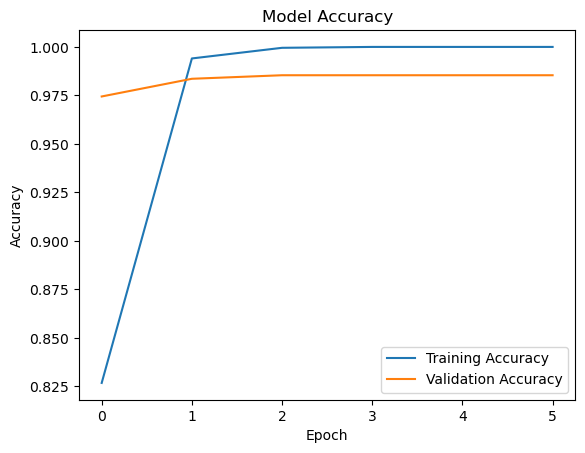

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
flipkart = pd.read_csv('flipkart_data.csv')

In [ ]:
flipkart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9976 non-null   object
 1   rating  9976 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 156.0+ KB


In [ ]:
np.sort(pd.unique(flipkart['rating']))

array([1, 2, 3, 4, 5])

<Axes: xlabel='rating', ylabel='count'>

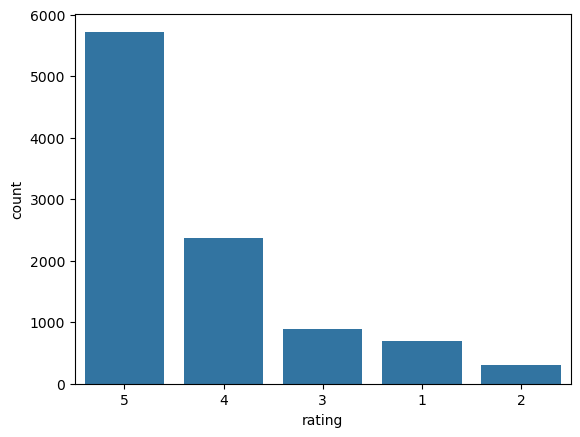

In [ ]:
sns.countplot(data=flipkart,
              x='rating',
              order=flipkart.rating.value_counts().index)

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

# def remove_emojis(text):
#     emoji_pattern = re.compile(
#         "["
#         "\U0001F600-\U0001F64F"  # Emoticons
#         "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
#         "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
#         "\U0001F700-\U0001F77F"  # Alchemical Symbols
#         "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#         "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#         "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#         "\U0001FA00-\U0001FA6F"  # Chess Symbols
#         "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#         "\U00002702-\U000027B0"  # Dingbats
#         "\U000024C2-\U0001F251"  # Enclosed Characters
#         "]+",
#         flags=re.UNICODE
#     )
#     return emoji_pattern.sub(r'', text)

In [ ]:
punctuations_list = string.punctuation
flipkart['review'] = flipkart['review'].str.lower().\
    apply(lambda x: remove_punctuations(x)).\
    apply(lambda x: remove_stopwords(x))
# flipkart['review'] = flipkart['review'].apply(lambda text: remove_emojis(text))
flipkart.head(10)

,review,rating
0,nice produt like design lot easy carry looked ...,5
1,awesome soundvery pretty see nd sound quality ...,5
2,awesome sound quality pros 78 hrs battery life...,4
3,think good product per quality also design qui...,5
4,awesome bass sound quality good bettary long l...,5
5,awsome sound powerful bass battery backup also...,5
6,product sound clear excellent bass obviously g...,4
7,u buy thispros1 sound quality build quality aw...,4
8,first want talk sound quality sound quality be...,5
9,good looking super fine clear sound power full...,5


In [ ]:
flipkart['rating'].value_counts()

rating
5    5726
4    2365
3     884
1     691
2     310
Name: count, dtype: int64

In [ ]:
class_1 = flipkart[flipkart['rating'] == 1]
class_2 = flipkart[flipkart['rating'] == 2]
class_3 = flipkart[flipkart['rating'] == 3]
class_4 = flipkart[flipkart['rating'] == 4]
class_5 = flipkart[flipkart['rating'] == 5]

class_1_oversampled = class_1.sample(n=len(class_5), replace=True, random_state=42)
class_2_oversampled = class_2.sample(n=len(class_5), replace=True, random_state=42)
class_3_oversampled = class_3.sample(n=len(class_5), replace=True, random_state=42)
class_4_oversampled = class_4.sample(n=len(class_5), replace=True, random_state=42)

oversampled_df = pd.concat([class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_oversampled, class_5])
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(oversampled_df['rating'].value_counts())
oversampled_df.head(10)

rating
4    5726
1    5726
3    5726
2    5726
5    5726
Name: count, dtype: int64


,review,rating
0,nice sound qualitybassi got min 6hr battery li...,4
1,wastage moneyread,1
2,loads bass bass lover buy thisheadphones balan...,3
3,ear pain elastic part tightread,2
4,battery backup okay generally gives 34 hrs usa...,3
5,cant wear 1 hourread,1
6,product goodread,3
7,sound quality good 56 moths facing issue bluet...,3
8,grip tight cant wear 30 min ears start paining...,2
9,average quality go want something low budgetread,4


In [ ]:
X = oversampled_df['review']
y = oversampled_df['rating']

flipkart_X_train, flipkart_X_test, flipkart_y_train, flipkart_y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=42
)

flipkart_y_train = flipkart_y_train.values - 1
flipkart_y_test = flipkart_y_test.values - 1

print(flipkart_y_train)
print(flipkart_y_test)
print(flipkart_y_train.shape)
print(flipkart_y_test.shape)

[0 3 4 ... 1 1 4]
[1 4 3 ... 3 2 1]
(22904,)
(5726,)


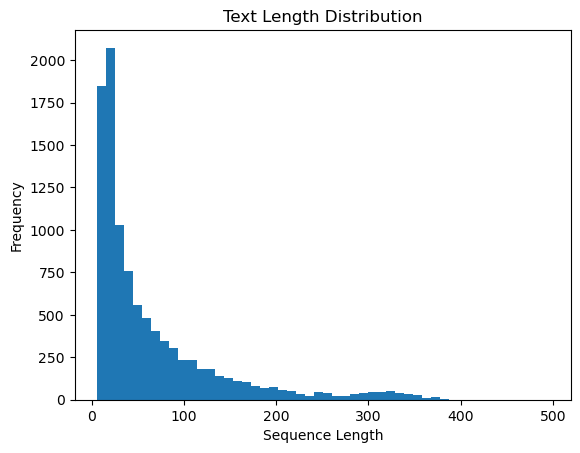

90th Percentile: 160.0


In [ ]:
lengths = [len(seq) for seq in flipkart.review]
plt.hist(lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

print(f"90th Percentile: {np.percentile(lengths, 90)}")


In [ ]:
flipkart_tokenizer = Tokenizer()
flipkart_tokenizer.fit_on_texts(flipkart_X_train)

flipkart_train_sequences = flipkart_tokenizer.texts_to_sequences(flipkart_X_train)
flipkart_test_sequences = flipkart_tokenizer.texts_to_sequences(flipkart_X_test)

max_len = 160

flipkart_train_sequences = pad_sequences(flipkart_train_sequences,
                                 maxlen=max_len,
                                 padding='post',
                                 truncating='post')

flipkart_test_sequences = pad_sequences(flipkart_test_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')

In [ ]:
def build_flipkart_model(hp, max_len= 160):
    hp_embedding_output_dim = hp.Choice('embedding_output_dim', [32, 64, 128])
    hp_lstm_unit = hp.Choice('lstm_units', [16, 32, 64, 128])
    hp_dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_unit_1 = hp.Choice('dense_units', [32, 64 ,128])
    hp_dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = Sequential()
    model.add(Embedding(
        input_dim= len(flipkart_tokenizer.word_index) + 1,
        output_dim= hp_embedding_output_dim,
        input_length = max_len
    ))
    model.add(Bidirectional(LSTM(hp_lstm_unit)))
    model.add(Dropout(hp_dropout_rate_1))
    model.add(Dense(hp_dense_unit_1, activation='relu'))
    model.add(Dropout(hp_dropout_rate_2))
    model.add(Dense(5, activation='softmax'))

    model.compile(
        loss= SparseCategoricalCrossentropy(),
        optimizer=Adam(learning_rate= hp_learning_rate),
        metrics=['accuracy']
    )
    return model


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose = 1
)

In [ ]:
flipkart_tuner = kt.Hyperband(
    build_flipkart_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    executions_per_trial=2,
    directory='tuner_results_2',
    project_name='flipkart_bilstm_tuning',
    hyperband_iterations=2,
    max_consecutive_failed_trials=3,
)

Reloading Tuner from tuner_results_2/flipkart_bilstm_tuning/tuner0.json


In [ ]:
flipkart_tuner.search(
    flipkart_train_sequences,
    flipkart_y_train,
    epochs=20,
    validation_data=(flipkart_test_sequences, flipkart_y_test),
    callbacks=[early_stopping, reduce_lr]
)

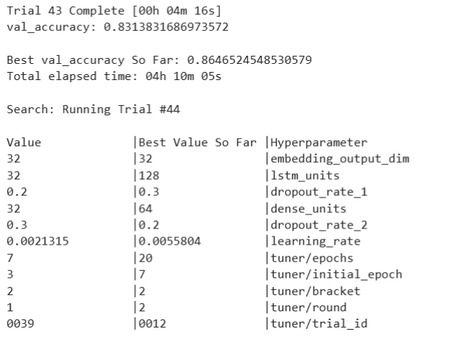

In [ ]:
from PIL import Image

img = Image.open('flipkart_tuner_results.png')
base_width = 450
w_percent = base_width / float(img.size[0])
new_height = int(float(img.size[1]) * w_percent)
resized_img = img.resize((base_width, new_height), Image.LANCZOS)
resized_img.save('resized_flipkart_tuner_results.png')
resized_img.show()



In [ ]:
best_hps_2 = flipkart_tuner.get_best_hyperparameters(num_trials = 1)[0]
flipkart_model = flipkart_tuner.hypermodel.build(best_hps_2)

In [ ]:
print("Best Hyperparameters:")
for param, value in best_hps_2.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
embedding_output_dim: 32
lstm_units: 128
dropout_rate_1: 0.30000000000000004
dense_units: 64
dropout_rate_2: 0.2
learning_rate: 0.005580431997706447
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [ ]:
history = flipkart_model.fit(
    flipkart_train_sequences,
    flipkart_y_train,
    validation_data=(flipkart_test_sequences, flipkart_y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
history = flipkart_model.fit(
    flipkart_train_sequences,
    flipkart_y_train,
    validation_data=(flipkart_test_sequences, flipkart_y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


I0000 00:00:1732831545.041540     535 cuda_dnn.cc:529] Loaded cuDNN version 90300


716/716 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.4642 - loss: 1.2044 - val_accuracy: 0.7197 - val_loss: 0.6230 - learning_rate: 0.0056
Epoch 2/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.7733 - loss: 0.5415 - val_accuracy: 0.8023 - val_loss: 0.4856 - learning_rate: 0.0056
Epoch 3/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.8367 - loss: 0.3917 - val_accuracy: 0.8048 - val_loss: 0.4547 - learning_rate: 0.0056
Epoch 4/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.8590 - loss: 0.3320 - val_accuracy: 0.8189 - val_loss: 0.4252 - learning_rate: 0.0056
Epoch 5/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.8658 - loss: 0.3056 - val_accuracy: 0.8297 - val_loss: 0.4474 - learning_rate: 0.0056
Epoch 6/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8752 - loss: 0.2899
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.002790215890854597.
716/716 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.8752 - loss: 0.2899 - 

In [ ]:
test_loss_2, test_accuracy_2 = flipkart_model.evaluate(flipkart_test_sequences,flipkart_y_test)
print('Test Loss :',test_loss_2)
print('Test Accuracy :',test_accuracy_2)

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8532 - loss: 0.5924
Test Loss : 0.5744140148162842
Test Accuracy : 0.8569682240486145


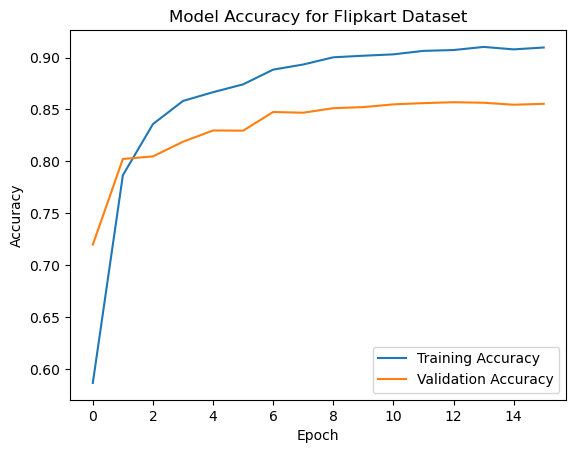

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for Flipkart Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
flipkart_model.save('flipkart_model.keras')

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


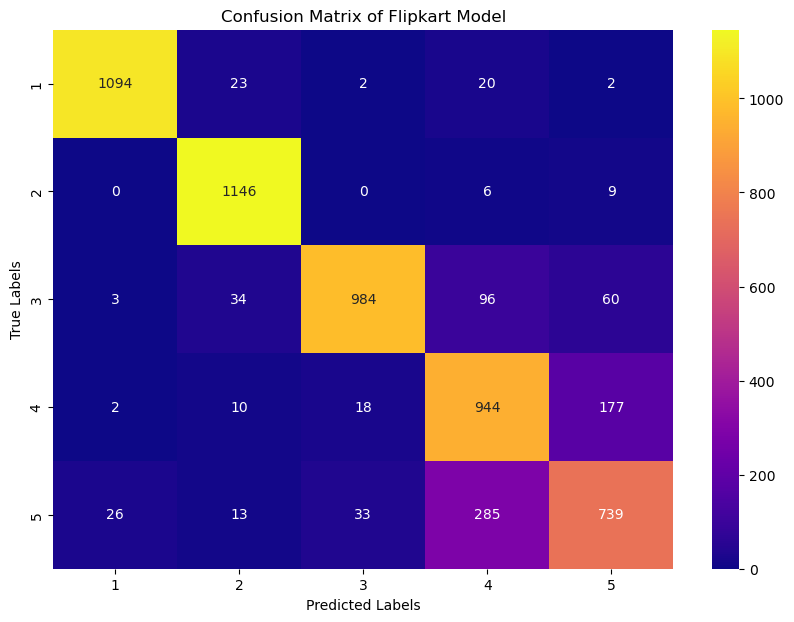

Macro F1 Score: 0.8558


In [ ]:
flipkart_model = load_model('flipkart_model.keras')

y_pred = flipkart_model.predict(flipkart_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(flipkart_y_test + 1, y_pred_classes + 1)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Flipkart Model')
plt.show()

f1_macro = f1_score(flipkart_y_test, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1_macro:.4f}')
